# Installation of Packages


In [ ]:

# Install Transformers
!pip install transformers==3
# To get model summary
!pip install torchinfo

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
# specify GPU
device = torch.device(“cuda”)

# Load Dataset


In [ ]:
# We have prepared a chitchat dataset with 5 labels
df = pd.read_excel(“/content/drive/MyDrive/Datasets/chitchat.xlsx”)
df.head()

In [ ]:
df[‘label’].value_counts()

In [ ]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
# check class distribution
df['label'].value_counts(normalize = True)

In [ ]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = df[‘text’], df[‘label’]

In [ ]:
# Data prepration


In [ ]:
# BERT Model
# We can import the Bert model as below.

from transformers import AutoModel, BertTokenizerFast
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(‘bert-base-uncased’)
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained(‘bert-base-uncased’)


# Roberta Model
# We can import the Roberta model as below.

from transformers import RobertaTokenizer, RobertaModel
# Load the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(‘roberta-base’)
# Import Roberta pretrained model
bert = RobertaModel.from_pretrained(‘roberta-base’)


# DistilBert Model
# We can import the DistilBert model as below.

from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(‘distilbert-base-uncased’)
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained(“distilbert-base-uncased”)


# We will be using DistilBert model for this example.

# Sample data for distilbert-base-uncased tokenizer

text = ["this is a distil bert model.","data is oil"]
# Encode the text
encoded_input = tokenizer(text, padding=True,truncation=True, return_tensors='pt')
print(encoded_input)


In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)
# Based on the histogram we are selecting the max len as 8
max_seq_len = 8

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

## Define Model Architecture


In [ ]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,5)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [ ]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)
from torchinfo import summary
summary(model)

# Fine Tune model

In [ ]:
# Optimizer
# Using the Optimizer we reduce the loss during backpropagation through the network.

from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)


In [ ]:
# Find Class Weights


from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight(‘balanced’, np.unique(train_labels), train_labels)
print(class_wts)

In [ ]:
# Balancing the weights while calculating the error
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 




# Setting up the epochs
# empty lists to store training and validation loss of each epoch

train_losses=[]
# number of training epochs
epochs = 200
# We can also use learning rate scheduler to achieve better results
lr_sch = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

## Fine-Tune the model

In [ ]:
# function to train the model
def train():
  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # clear calculated gradients
    optimizer.zero_grad()
  
    # We are not using learning rate scheduler as of now
    # lr_sch.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
# compute the training loss of the epoch
avg_loss = total_loss / len(train_dataloader)
  
# predictions are in the form of (no. of batches, size of batch, no. of classes).
# reshape the predictions in form of (number of samples, no. of classes)
total_preds  = np.concatenate(total_preds, axis=0)
#returns the loss and predictions
return avg_loss, total_preds

## Start Model Training

In [ ]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nTraining Loss: {train_loss:.3f}')


## Get Predictions for Test Data

In [ ]:
def get_prediction(str):
 str = re.sub(r’[^a-zA-Z ]+’, ‘’, str)
 test_text = [str]
 model.eval()
 
 tokens_test_data = tokenizer(
 test_text,
 max_length = max_seq_len,
 pad_to_max_length=True,
 truncation=True,
 return_token_type_ids=False
 )
 test_seq = torch.tensor(tokens_test_data[‘input_ids’])
 test_mask = torch.tensor(tokens_test_data[‘attention_mask’])
 
 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
 preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print(“Intent Identified: “, le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]
def get_response(message): 
  intent = get_prediction(message)
  for i in data['intents']: 
    if i["tag"] == intent:
      result = random.choice(i["responses"])
      break
  print(f"Response : {result}")
  return "Intent: "+ intent + '\n' + "Response: " + result

In [ ]:
get_response(“why dont you introduce yourself”)

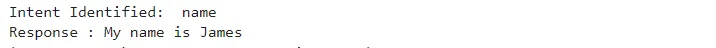